In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import hbar, elementary_charge
from scipy.optimize import brentq
reduced_flux_quantum = hbar / (2 * elementary_charge)

## Import data

In [2]:
gate_voltages = np.loadtxt('data/I_sw_0_5.txt', usecols=[0]) # cutter gate values for which we have extracted switching currents, in Volts
switching_currents = 1e-9 * np.loadtxt('data/I_sw_0_5.txt', usecols=[1]) # switching currents extracted from data, in Amperes

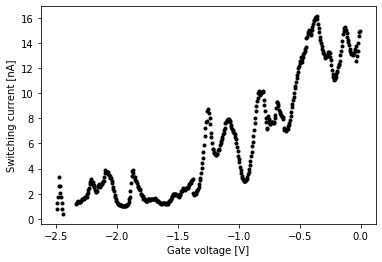

In [3]:
plt.scatter(gate_voltages, 1e9*switching_currents, marker='.', c='k')
plt.ylabel("Switching current [nA]")
plt.xlabel("Gate voltage [V]")
plt.show()

In [6]:
gate_voltages_cqed = np.loadtxt('data/qubit_freq.txt', usecols=[0]) # gate voltages for which we have extracted qubit frequency
qubit_frequencies_measured = np.loadtxt('data/qubit_freq.txt', usecols=[1]) # measured qubit frequencies, in GHz

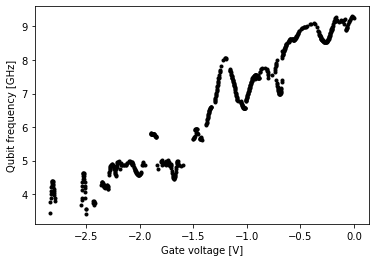

In [7]:
plt.scatter(gate_voltages_cqed, qubit_frequencies_measured, marker='.', c='k')
plt.ylabel("Qubit frequency [GHz]")
plt.xlabel("Gate voltage [V]")
plt.show()

## Infer critical current from switching current

We assume that in the DC configuration of the device, the qubit Josephson junction is described by an underdamped RCSJ model with quality factor $Q\gg 1$ and a sinusoidal current-phase relation $I=I_0\sin\phi$. In this limit, the equation for the switching current $I_s$ is:

\begin{equation}
\frac{I_s}{I_0} = \frac{2+4/\pi}{Q}+\frac{2+\pi}{Q^2}
\end{equation}

This is Eq. (20) from Kautz-Martinis, except that the switching current $I_s$ replaces the equal-probability current $I_e$.
This replacement is justified if the temperature is high enough that there is no hysteresis in the I-V curve of the underdamped junction.
Indeed, in this limit the switching and retrapping currents $I_s$ and $I_r$ are both equal to $I_e$.
The hysteresis observed in the data is small, so the assumption should be reasonable.

The quality factor $Q$ is:

\begin{equation}
Q = \sqrt{\frac{2e I_0 R^2C}{\hbar}}
\end{equation}

where the resistance $R$ is:

\begin{equation}
R = \frac{R_J R_\textrm{line}}{R_J + R_\textrm{line}}
\end{equation}

Here, $R_\textrm{line}$ is the line resistance measured with both JJs in the zero-voltage state, and $R_J$ is the shunt resistance of the junction.

Replacing the expression for $Q$ in the first equation, and introducing the Josephson energy $E_J = \hbar I_0/2e$, we obtain an equation for $I_s$ as a function of $I_0$ and $R$:

\begin{equation}
I_s = \sqrt{\frac{\hbar I_0}{2eC}}\,\frac{2+4/\pi}{R} + \frac{\hbar}{2eC}\,\frac{2+\pi}{R^2}
\end{equation}

In this equation, both $I_0$ and $R$ on the right hand side are a function of the gate voltage $V_Q$, the latter through the dependence on the shunt resistance $R_J$.
We assume for simplicity that the shunt resistance $R_J$ is equal to the resistance in the normal state $R_N$, and that $R_N$ is related to $I_0$ via Ambegaokar-Baratoff formula:

\begin{equation}
I_0R_J = \pi\Delta/2e
\end{equation}

With this assumption, we obtain a right hand side which only depends on $I_0$. We then solve for $I_0$ at every value of the gate voltage numerically, using the experimentally extracted value for $I_s$ at each gate voltage and the gate-independent quantities $\Delta, C, R_\textrm{line}$.

In [8]:
def find_critical_current(Is, gap, C, Rline):
    """Estimates the critical current of a junction described by the underdamped
    RCSJ model in the limit of weak hysteresis and Q>>1 (see derivation above)."""
    def f(I0):
        RJ = np.pi * gap / (2 * elementary_charge * I0)
        R = RJ * Rline / (RJ + Rline)
        term1 = np.sqrt(I0 * reduced_flux_quantum / C) * (2 + 4/np.pi) / R
        term2 = reduced_flux_quantum * (2 + np.pi) / (C * R**2)
        return Is - term1 - term2
    return brentq(f, Is, 100e-9)

In [9]:
gap = 190e-6 / 6.242e18 #Joules, energy gap estiamte from tunneling measurements
C = 37.8e-15 #Farad, estimated from simulations
Rline = 56.9*1e3 #Ohm, measured with both junctions in zero-voltage state

In [10]:
critical_currents = np.array([find_critical_current(i, gap, C, Rline) for i in switching_currents])

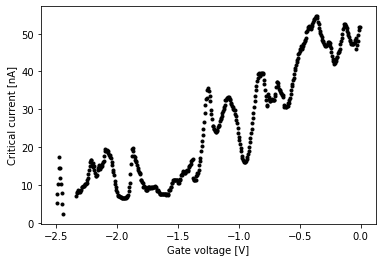

In [11]:
plt.scatter(gate_voltages, 1e9*critical_currents, marker='.', c='k')
plt.ylabel("Critical current [nA]")
plt.xlabel("Gate voltage [V]")
plt.show()

## Consistency check: quality factors

To check that we are applying our formula consistently, we look at what quality factors our estimate of $I_0$ gives.
The values are all larger than 10, so we are satisfied.

In [12]:
def return_quality_factor(I0, C, gap):
    RJ = np.pi * gap / (2 * elementary_charge * I0)
    R = RJ * Rline / (RJ + Rline)
    Q = np.sqrt(I0 * R**2 * C / reduced_flux_quantum)
    return Q

In [13]:
Qs = return_quality_factor(critical_currents, C, gap)

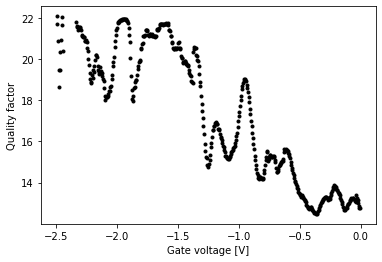

In [14]:
plt.scatter(gate_voltages, Qs, marker='.', c='k')
plt.ylabel("Quality factor")
plt.xlabel("Gate voltage [V]")
plt.show()

## Infer qubit frequency from Josephson energy

We convert the critical current $I_0$ and the capacitance $Q$ to Josephson and charging energies $E_J, E_c$, then compute qubit frequency numerically, at the charge degeneracy point.

In [15]:
def determine_qubit_frequency(EJ, Ec, Ng=0.5, N=100):
    """Computes the energy gap of the EJ-Ec model
    at the charge degeneracy point Ng=0.5"""
    n_op = np.diag(np.arange(-N, N + 1, 1, dtype=int)) - Ng * np.eye(2*N+1)
    ham = 4 * Ec * n_op@n_op
    ham += 0.5 * EJ * np.eye(2*N+1, k=1)
    ham += 0.5 * EJ * np.eye(2*N+1, k=-1)
    evals = np.linalg.eigvalsh(ham)
    freq = evals[1] - evals[0]
    return freq

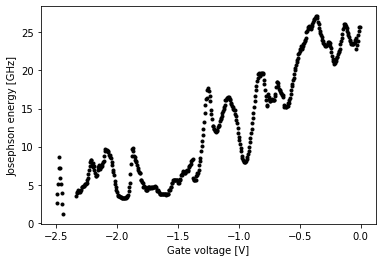

In [16]:
# Get Josephson energies in GHz from the estimated critical currents
josephson_energies = critical_currents / (4 * np.pi * elementary_charge) * 1e-9# GHz
plt.scatter(gate_voltages, josephson_energies, marker='.', c='k')
plt.ylabel("Josephson energy [GHz]")
plt.xlabel("Gate voltage [V]")
plt.show()

In [17]:
# Determine qubit frequency from the standard transmon Hamiltonian
Ec = (elementary_charge**2 / (2 * C)) / (2*np.pi * hbar) * 1e-9 # GHz
qubit_frequencies = np.array([determine_qubit_frequency(EJ, Ec) for EJ in josephson_energies])

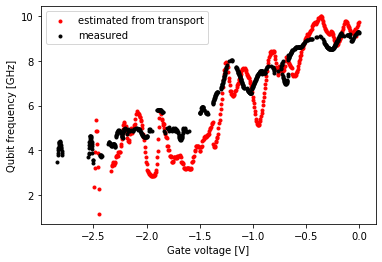

In [18]:
plt.scatter(gate_voltages, qubit_frequencies, marker='.', c='r', label='estimated from transport')
plt.scatter(gate_voltages_cqed, qubit_frequencies_measured, marker='.', c='k', label='measured')
plt.legend()
plt.ylabel("Qubit frequency [GHz]")
plt.xlabel("Gate voltage [V]")
plt.show()